In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

The data can be obtained from https://www.kaggle.com/c/dont-call-me-turkey

In [2]:
!pwd

/Users/sdubnov


In [3]:
cd Downloads/dont-call-me-turkey/

/Users/sdubnov/Downloads


In [5]:
!ls

model.h5              sample_submission.csv train.json
model.json            test.json


Other possible pretrained embeddings: L3open, EdgeL3, YAMnet
Can try also traditional audio features from librosa: spectrogram, melspect, mfcc

In [6]:
from keras import Sequential
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
#from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,CuDNNLSTM, GRU, CuDNNGRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization,LSTM, GRU, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Using TensorFlow backend.


In [7]:
train = pd.read_json('train.json')
display(train.shape)

(1195, 5)

In [8]:
type(train)

pandas.core.frame.DataFrame

In [9]:
train.head()

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0


In [10]:
train_train, train_val = train_test_split(train, random_state = 42)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values
xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

In [12]:
x_train = pad_sequences(xtrain)
x_val = pad_sequences(xval, maxlen=10)
y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

In [13]:
mat = x_train[2]
type(x_train)
x_train[1].shape

(10, 128)

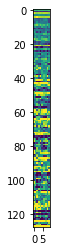

In [14]:
plt.figure(figsize=(2,4))
plt.imshow(mat.T)

In [15]:
model = Sequential()
model.add(BatchNormalization(momentum=0.98,input_shape=(10, 128)))
#model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model.add(Bidirectional(GRU(128, return_sequences = True)))
model.add(Bidirectional(GRU(64, return_sequences = True)))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = optimizers.Nadam(lr=0.001), metrics=['accuracy'])
print(model.summary())

W0412 11:02:45.318011 140735614509952 deprecation.py:506] From /anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0412 11:02:46.091561 140735614509952 deprecation.py:323] From /anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 10, 128)           512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 256)           197376    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 128)           123264    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 322,433
Trainable params: 322,177
Non-trainable params: 256
_________________________________________________________________
None


In [16]:
Winit = model.get_weights()

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
#fit on a portion of the training data, and validate on the rest
history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2)

W0412 11:02:48.297266 140735614509952 module_wrapper.py:139] From /anaconda2/envs/Python37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 896 samples, validate on 299 samples
Epoch 1/16
 - 2s - loss: 0.5552 - accuracy: 0.7355 - val_loss: 0.4800 - val_accuracy: 0.8629
Epoch 2/16
 - 0s - loss: 0.2858 - accuracy: 0.9319 - val_loss: 0.3908 - val_accuracy: 0.8997
Epoch 3/16
 - 0s - loss: 0.1970 - accuracy: 0.9509 - val_loss: 0.3250 - val_accuracy: 0.9097
Epoch 4/16
 - 0s - loss: 0.1489 - accuracy: 0.9531 - val_loss: 0.2765 - val_accuracy: 0.9130
Epoch 5/16
 - 0s - loss: 0.1224 - accuracy: 0.9609 - val_loss: 0.2474 - val_accuracy: 0.9197
Epoch 6/16
 - 0s - loss: 0.1036 - accuracy: 0.9676 - val_loss: 0.2298 - val_accuracy: 0.9097
Epoch 7/16
 - 0s - loss: 0.0924 - accuracy: 0.9643 - val_loss: 0.2274 - val_accuracy: 0.9130
Epoch 8/16
 - 0s - loss: 0.0799 - accuracy: 0.9754 - val_loss: 0.1942 - val_accuracy: 0.9197
Epoch 9/16
 - 0s - loss: 0.0691 - accuracy: 0.9788 - val_loss: 0.2081 - val_accuracy: 0.9030
Epoch 10/16
 - 0s - loss: 0.0562 - accuracy: 0.9833 - val_loss: 0.2074 - val_accuracy: 0.9064
Epoch 11/16
 - 0s - los

In [19]:
history_dict=history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [20]:
def plot_history(history):
    history_dict=history.history
    history_dict.keys()
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss_values, '-bo')
    # b+ is for "blue crosses"
    plt.plot(epochs, val_loss_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.figure()
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, acc_values, '-bo')
    plt.plot(epochs, val_acc_values, '-b+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

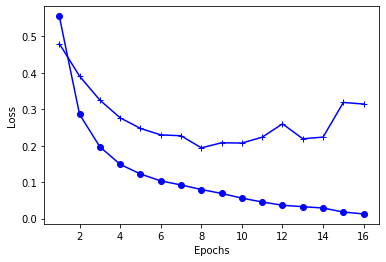

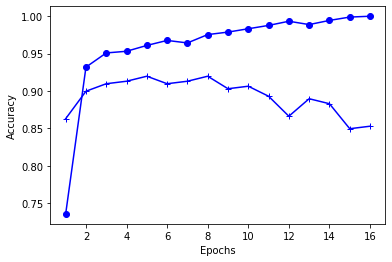

In [21]:
plot_history(history)

In [22]:
if 0:
    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")


### Early Stopping 

In [23]:
model.set_weights(Winit)

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[early_stop])

Train on 896 samples, validate on 299 samples
Epoch 1/16
 - 0s - loss: 0.5130 - accuracy: 0.7400 - val_loss: 0.4170 - val_accuracy: 0.8896
Epoch 2/16
 - 0s - loss: 0.2080 - accuracy: 0.9397 - val_loss: 0.3197 - val_accuracy: 0.9130
Epoch 3/16
 - 0s - loss: 0.1403 - accuracy: 0.9587 - val_loss: 0.2695 - val_accuracy: 0.9197
Epoch 4/16
 - 0s - loss: 0.1124 - accuracy: 0.9665 - val_loss: 0.2472 - val_accuracy: 0.9064
Epoch 5/16
 - 0s - loss: 0.0953 - accuracy: 0.9654 - val_loss: 0.2332 - val_accuracy: 0.9164
Epoch 6/16
 - 0s - loss: 0.0772 - accuracy: 0.9766 - val_loss: 0.2167 - val_accuracy: 0.9130
Epoch 7/16
 - 0s - loss: 0.0693 - accuracy: 0.9743 - val_loss: 0.2444 - val_accuracy: 0.8763
Epoch 8/16
 - 0s - loss: 0.0526 - accuracy: 0.9855 - val_loss: 0.2127 - val_accuracy: 0.8963
Epoch 9/16
 - 0s - loss: 0.0409 - accuracy: 0.9900 - val_loss: 0.2568 - val_accuracy: 0.8595
Epoch 10/16
 - 0s - loss: 0.0318 - accuracy: 0.9933 - val_loss: 0.2587 - val_accuracy: 0.8662
Epoch 11/16
 - 0s - los

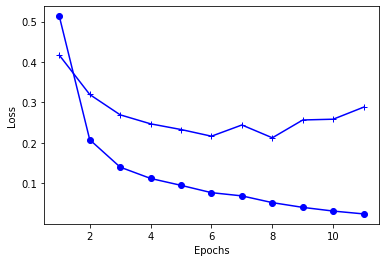

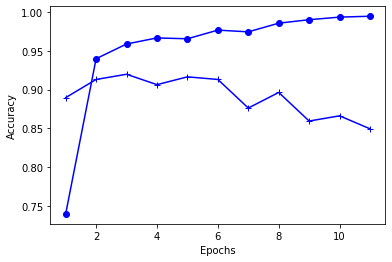

In [26]:
plot_history(history)

### Reduce Learning Rate

In [27]:
model.set_weights(Winit)

In [28]:
#early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3,  restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_lr=1e-8)

history = model.fit(x_train, y_train,batch_size=512, epochs=16, validation_data=[x_val, y_val],verbose = 2,callbacks=[reduce_lr,early_stop])

Train on 896 samples, validate on 299 samples
Epoch 1/16
 - 0s - loss: 0.5073 - accuracy: 0.7556 - val_loss: 0.4052 - val_accuracy: 0.8963
Epoch 2/16
 - 0s - loss: 0.1996 - accuracy: 0.9431 - val_loss: 0.3081 - val_accuracy: 0.9097
Epoch 3/16
 - 0s - loss: 0.1346 - accuracy: 0.9576 - val_loss: 0.2626 - val_accuracy: 0.9197
Epoch 4/16
 - 0s - loss: 0.1060 - accuracy: 0.9609 - val_loss: 0.2486 - val_accuracy: 0.8997
Epoch 5/16
 - 0s - loss: 0.0866 - accuracy: 0.9710 - val_loss: 0.2276 - val_accuracy: 0.9097

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/16
 - 0s - loss: 0.0716 - accuracy: 0.9777 - val_loss: 0.2216 - val_accuracy: 0.9097
Epoch 7/16
 - 0s - loss: 0.0696 - accuracy: 0.9777 - val_loss: 0.2171 - val_accuracy: 0.9097

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 8/16
 - 0s - loss: 0.0682 - accuracy: 0.9777 - val_loss: 0.2127 - val_accuracy: 0.9064
Epoch 9/16
 - 0s - loss: 0.0683 - accuracy: 0.

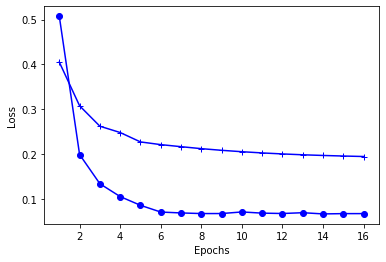

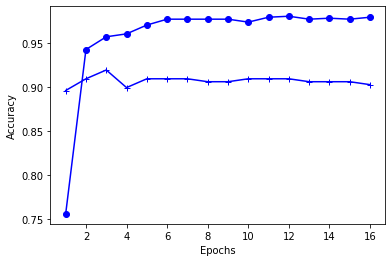

In [29]:
plot_history(history)

### ROC

In [141]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_val).ravel()
fpr, tpr, thresholds = roc_curve(yval, y_pred)

W0412 17:27:28.172221 140735614509952 legend.py:1282] No handles with labels found to put in legend.


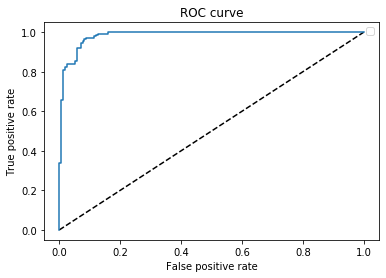

In [142]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr) # label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

For threshold 0.33313876 we get: tpr:  0.9225352112676056 fpr:  0.05732484076433121


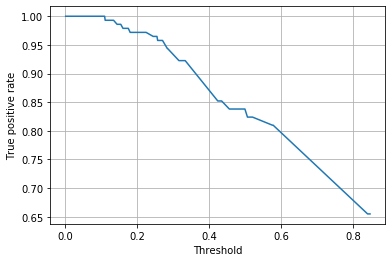

In [166]:
ind = [i for i, val in enumerate(tpr) if val>0.5] 
plt.plot(thresholds[ind],tpr[ind])
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('Threshold')
plt.ylabel('True positive rate')
plt.grid(b=True)

tpr_percentage = 0.90
indval = [i for i, val in enumerate(tpr) if val>=tpr_percentage]
print("For threshold", thresholds[indval[0]], "we get: tpr: ",tpr[indval[0]], "fpr: ", fpr[indval[0]])
threshold_percentage = thresholds[indval[0]]

In [174]:
#jdemonstrate the concept of tpr in terms of confusion matrix
from sklearn.metrics import confusion_matrix
yres = np.zeros(np.shape(yval))
yind = [i for i, res in enumerate(y_pred) if res >= threshold_percentage]
yres[yind] = 1
conf_mat = confusion_matrix(yval, yres)
tn, fp, fn, tp = conf_mat.ravel()
print("Confusion Matrix: \n ", conf_mat)
print("tpr from Confusion Matrix:", tp/(tp+fn))

Confusion Matrix: 
  [[148   9]
 [ 11 131]]
tpr from Confusion Matrix: 0.9225352112676056


#### About differences between accuracy and ROC check 

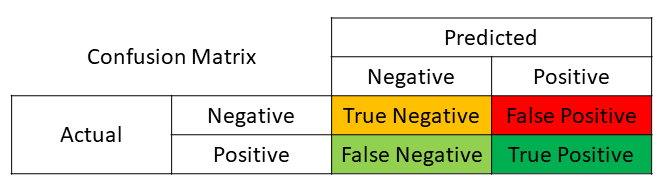


https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019

### Classifier with alternative threshold

In [81]:
test = pd.read_json('test.json')
test.head()

,audio_embedding,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",pyKh38FXD3E,10,0
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",THhP1idrWXA,40,30
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",jsw3T6GY2Nw,40,30
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",nFkXTMHcjMU,24,14
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",Au8g9kAlrLQ,40,30


In [116]:
xtest = [k for k in test['audio_embedding']]
x_test = pad_sequences(xtest)

In [106]:
results = model.predict(np.array(x_test))
results[0]

array([0.00334969], dtype=float32)

In [126]:
#yres = [1 for i, res in enumerate(results) if res > threshold_percentage]

for i, res in enumerate(results[0:10]):
    if res > threshold_percentage:
        print(i, ': Call me turkey')
    else:
        print(i, ': Don\'t call me turkey')
        

0 : Don't call me turkey
1 : Don't call me turkey
2 : Don't call me turkey
3 : Don't call me turkey
4 : Call me turkey
5 : Don't call me turkey
6 : Don't call me turkey
7 : Don't call me turkey
8 : Call me turkey
9 : Call me turkey


### Inspecting individual layers

In [ ]:
layer_names=[layer.name for layer in model.layers]

In [ ]:
print(layer_names)

In [ ]:
layer_name = 'bidirectional_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
mat_GRU=intermediate_output[2]
mat_GRU.shape

In [ ]:
plt.subplot(221)
plt.imshow(mat.T)
plt.subplot(222)
plt.imshow(mat_GRU.T)